# Modèle CRR pour l'évaluation du prix d'un Put Américain

## Introduction

Nous considérons un modèle binomial de type CRR (Cox-Ross-Rubinstein) avec $n$ périodes pour modéliser l'évolution du prix d'un sous-jacent $X_n$. Ce modèle repose sur un arbre binaire à chaque étape, où il existe deux états possibles à chaque nœud : soit le prix du sous-jacent augmente d'un facteur $u$, soit il diminue d'un facteur $d$. Nous fixons une maturité $T$ et un pas de temps $\Delta t$. À l'instant $n \Delta t$ périodes, nous obtenons $n+1$ états possibles pour le prix de l'actif. On suppose également un taux d'intérêt $r$, de sorte qu'un actif sans risque évolue avec un facteur $e^{r \Delta t}$ à chaque pas de temps. .

D'aprés l'article partagé: afin d'assurer que la procédure du modèle binomial présente une convergence faible vers le processus de Black-Scholes, le modèle Cox, Ross, et Rubinstein (CRR) suggère les paramètres suivants :

$$ u = e^{\sigma \sqrt{\Delta t}} $$

$$ d = \frac{1}{u} $$

$$ p = \frac{1}{2} \left( 1 + \left( r - \frac{1}{2} \sigma^2 \right) \frac{1}{\sigma} \sqrt{\Delta t} \right) $$


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [14]:
sns.set_style("whitegrid")
mpl.rcParams['figure.dpi'] = 100

params_grid = {"color": 'lightgrey', "linestyle": 'dotted', "linewidth": 0.7 }

## Objectif


Le prix d'un put américain est exprimé comme suit :

$$
\sup_{\tau \in \mathbf{A}} \mathbb{E}^{\mathbf{Q}}\left[ e^{-r \tau}(X_\tau - K)_+ \right]
$$
où $\mathbb{E}^{\mathbf{Q}}$ représente l'espérance sous la probabilité risque neutre  $\mathbf{Q}$ et $\mathbf{A}$ l'ensemble des temps d'arrêt inférieurs à T .

Ce notebook a pour objectif d'évaluer le prix d'un put américain en utilisant le modèle CRR et la programmation dynamique

## Modélisation


On modélise l'évolution du prix de l'actif de la manière suivante. Soit $(X_n)_{n \in \{0, \dots, N\}}$ la chaîne de Markov représentant la valeur de notre action à l'instant $n$. Pour un  ${n \in \{0, \dots, N\}}$ fixé, $X_n$ prend des valeurs dans $E_n$, où :
$$
E_n = \{ X_0 \cdot u^i \cdot d^j \mid i \in \mathbb{N}, j \in \mathbb{N}, i + j = n \}
$$

Les transitions $(Q_n)_{n = 0, \dots, N-1}$ de la chaîne de Markov sont définies par $Q_n(x, y) = \mathbb{Q}(X_{n+1} = y | X_{n} = x)$ et vérifient la relation suivante :

$$
\forall x, y \in E, \quad 
Q_n(x, y) = 
\begin{cases}
q_u & \text{si } y = x \cdot u, \\
1-q_u & \text{si } y = x \cdot d, \\
0 & \text{sinon}.
\end{cases}
$$











### Fonction de Gains ou Payoff

La fonction de gain, notée $\varphi$, est donnée par :

$$
\varphi_n(x) = (K - x)_+
$$

où $K$ est le strike du put 

In [15]:
#paramétres
N=30
K=100
X_0=100
T=1#
dt=T/N#
r=0.03
sigma=0.02
u=np.exp(sigma*np.sqrt(dt))
d=1/u
qu=0.5*(1+((r-0.5*sigma**2)/sigma)*np.sqrt(dt)) # proba que le prix augmente, qu>0
qd=1-qu
size_N=2
lw_N = 1.5

In [16]:
states=[]
for i in range(N+1):
    Si=np.array([X_0*(u**k)*(d**(i-k)) for k in range(i+1)])
    states.append(Si)

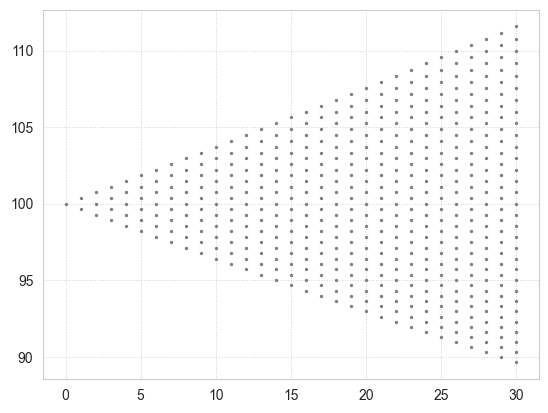

In [17]:
if N<31:
# prix du sous jacent aux différents pas de temps
    fig, ax = plt.subplots()
    ax.grid(**params_grid)
    for n in range(N+1):
        for z in states[n]:
            ax.scatter(n, z, color='grey', marker='o', s=2)

In [18]:
# matrice de transition de ma chaine de Markov
P = [np.zeros((len(states[n]), len(states[n+1]))) for n in range(N)]
for n in range(N):
    for i, x in enumerate(states[n]):
        for j, y in enumerate(states[n+1]):
            if abs(y - x*u)<0.001: P[n][i,j] = qu
            if abs(y - x*d)<0.001: P[n][i,j] = qd

In [19]:
# matrice payoff
def put(x,K):
    return max(0,K-x)
payoffs=[]
for i in range(N+1):
    Si=[put(X_0*(u**k)*(d**(i-k)),K) for k in range(i+1)]
    payoffs.append(Si)

In [20]:
#matrice valeur en chaque état 
V = [np.copy(payoffs[n]) for n in range(N+1)]
for n in reversed(range(N)):
    
    V[n] = np.maximum(payoffs[n], np.exp(-r*dt)*P[n] @ V[n+1]) 

## Prix du put

In [21]:
print("le prix du put est",V[0][0])

le prix du put est 0.22990980874687145


## Comparaison des résultats avec simulations de monte carlo

In [22]:
M = int(1e4)
stop = [(payoffs[n] == V[n]).astype('int') for n in range(N+1)] #frontière d'exercice

gains = np.zeros(M)
path = np.zeros(N+1, dtype='int')

for j in range(M):
    for n in range(1, N+1):
        path[n] = np.random.choice(np.arange(P[n-1].shape[1]), 1, p=P[n-1][path[n-1]])[0]
        if (stop[n][path[n]] == 1):
            break
    gains[j] = payoffs[n][path[n]]

m = np.mean(gains)
ic_size = 1.96 * np.sqrt(np.var(gains, ddof=1) / M) 

In [23]:
print(f"La valeur estimée avec {M} échantillons est : {m:.4}, et la variance estimée est {np.var(gains):.4}.")
print(f"La valeur réelle se trouve dans l'intervalle [{m-ic_size:.4}, {m+ic_size:.4}] avec 95% de probabilité (M = {M}).")
print(f"La valeur réelle est : {V[0][0]:.4}")



La valeur estimée avec 10000 échantillons est : 0.2324, et la variance estimée est 0.1138.
La valeur réelle se trouve dans l'intervalle [0.2258, 0.2391] avec 95% de probabilité (M = 10000).
La valeur réelle est : 0.2299
